# Catmon Image Classifier Iteration3 mobilenet_v2

**The aim of this notebook is to develop a catmon image classifier model 
that is able to classify catmon images as either Boo, Simba or Unknown.**

This notebook is based on an earlier version that used transfer learninga from the vgg16 model.

However, this proved very difficult to deploy on a standard raspberry pi (model 3b+).

The original is modified to use a mobilenet_v2 model to allow deployment on raspberry pi. 

mobilenet_v2 is much smaller on the pi:
```
pi@rpi3:~/.cache/torch/hub/checkpoints $ ls -al
total 1105776
drwxr-xr-x 2 pi pi      4096 Jul  5 22:55 .
drwxr-xr-x 3 pi pi      4096 Jul  5 17:08 ..
-rw------- 1 pi pi  14212972 Jul  5 22:33 mobilenet_v2-b0353104.pth
-rw------- 1 pi pi  22139423 Jul  5 22:55 mobilenet_v3_large-8738ca79.pth
-rw------- 1 pi pi  10306551 Jul  5 22:53 mobilenet_v3_small-047dcff4.pth
-rw------- 1 pi pi 532199577 Jul  5 22:48 vgg13-19584684.pth
-rw------- 1 pi pi 553433881 Jul  5 17:11 vgg16-397923af.pth
```

Iteration 3 uses 1000 images of boo and 1000 images of simba, split 
80-10-10\% between train, val and test.

---

Limitations: 
- basic transformation
- only uses catmon pics (by design)

To Do:
- Add non-catmon pics of boo and simba?
- Add other non-catmon pics of other objects for unknown?

## Set-up

In [1]:
!python --version

Python 3.9.12


In [2]:
from pathlib import Path
from PIL import Image
import copy
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
from torch.optim import lr_scheduler

from torchvision import datasets, transforms, models
import torchvision

In [ ]:
# show key versions
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")

In [95]:
# define image locations
IMAGENET_IMAGE = "images/ImageNet_categories_re_dogs_and_cats.jpg"
BOO_IMAGE = "images/unseen_boo_image_2015-03-08_141742.jpg"
SIMBA_IMAGE = "images/unseen_simba_image_2015-05-10_180756.jpg"
UNKNOWN_IMAGE = "images/unseen_unknown_image_2015-05-10_044850.jpg"
RANDOM_IMAGE1 = "images/Iris_germanica_(Purple_bearded_Iris)_Wikipedia.jpg"
RANDOM_IMAGE2 = "images/semi-semitrailer-truck-tractor-highway.jpg"
BOO_NON_CATMON_IMAGE = "images/boo_not_catmon_image.jpg"
SIMBA_NON_CATMON_IMAGE = "images/simba_not_catmon_image.jpg"

## Set device

In [3]:
# TD: use GPU if available

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## Prepare data

\# TD: all pretrained models in pytorch have certain requirements:
Ref: https://pytorch.org/vision/stable/models.html
- image size must be at least 224x224 pixels
- scaled to (0, 1)
- normalised with mean and std dev values given below:

In [5]:
mean = [0.485, 0.456, 0.406]
std  = [0.229, 0.224, 0.225]

In [6]:
# TD: apply series of transformations, including:
# - those given above 
# - random flipping
# - convert to tensor
# = note that normalisation happens after conversion to tensor

In [7]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

In [8]:
# TD: apply transformation to validation and test
# - note: resize and centre crop to get 224x224

In [9]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

Define location of training, validation and test datasets;
and batch size and number of workers

In [10]:
train_dir = 'datasets/catmon/train'
val_dir = 'datasets/catmon/val'
test_dir = 'datasets/catmon/test'

batch_size = 8
num_workers = 4

\# TD: note that the ImageNet dataset has many images of different breeds of cats and dogs
- labels: 151-290
- see list of Imagenet categories here: https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a

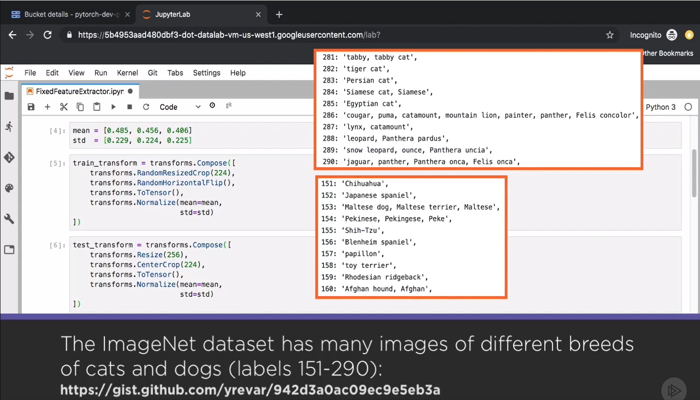

In [96]:
img = Image.open(IMAGENET_IMAGE)
img.resize((700, 400))

In [12]:
# TD: create dataset that points to training folder

In [13]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=train_transform)

In [14]:
train_data

Dataset ImageFolder
    Number of datapoints: 2234
    Root location: datasets/catmon/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [15]:
# TD: define data loader for training dataset
# - note that this uses batch size defined earlier and is shuffled

In [16]:
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=num_workers
)

In [17]:
# TD: and set-up validation dataset

In [18]:
val_data = datasets.ImageFolder(
    root=val_dir,
    transform=test_transform
)

In [19]:
val_data 

Dataset ImageFolder
    Number of datapoints: 279
    Root location: datasets/catmon/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [20]:
# TD: define the validation loader
# - note that this uses batch size defined earlier and is shuffled

In [21]:
val_loader = torch.utils.data.DataLoader(
    val_data, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=num_workers
)

In [22]:
# TD: and set-up test dataset

In [23]:
test_data = datasets.ImageFolder(
    root=test_dir,
    transform=test_transform
)

In [24]:
test_data 

Dataset ImageFolder
    Number of datapoints: 280
    Root location: datasets/catmon/test
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=bilinear, max_size=None, antialias=None)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [25]:
# TD: define the test loader
# - note that this uses batch size defined earlier and is shuffled

In [26]:
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size,
    shuffle=True, 
    num_workers=num_workers
)

In [27]:
# TD: define a dict with train, val and test dataloaders

In [28]:
dataloaders = {
    'train': train_loader,
    'val': test_loader,
    'test': test_loader
}

In [29]:
# TD: define a dict with train, val and test batch sizes

In [30]:
total_batch_sizes = {
    'train': len(train_loader),
    'val': len(val_loader),
    'test': len(test_loader)
}

In [31]:
total_batch_sizes

{'train': 280, 'val': 35, 'test': 35}

In [32]:
# Show the class names (categories)
# - expect 3: boo, simba and unknown

In [33]:
class_names = train_data.classes
print(class_names)

['boo', 'simba', 'unknown']


In [34]:
# TD: define helper function for displaying an image using matplotlib
# - convert image to numpy format (h, w, number of channels)
# - rescale by multiplying by std dev and adding mean
# - clip to range 0 to 1
# - pause after display

In [35]:
def imshow(inp, title):
    """Show given image with title, using matplotlib."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure (figsize = (12, 6))
    
    plt.imshow(inp)
    plt.title(title)
    plt.pause(1)

In [36]:
# TD: Show a few training images using torch makegrid utility func
# - expect sample of boo, simba and unknown (usually a dark image)

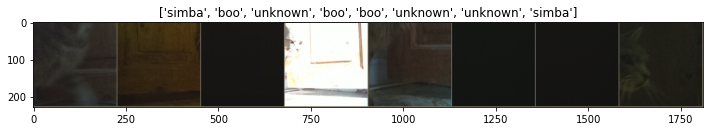

In [37]:
inputs, classes = next(iter(dataloaders['train']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

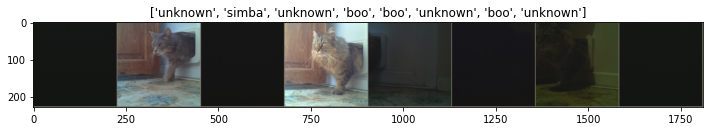

In [38]:
# TD: Show a few validation images using torch makegrid utility func
inputs, classes = next(iter(dataloaders['val']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

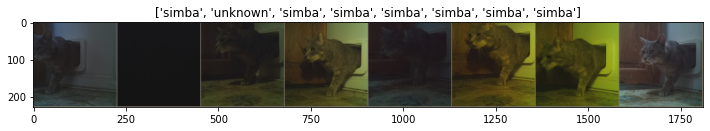

In [39]:
# TD: Show a few test images using torch makegrid utility func
inputs, classes = next(iter(dataloaders['test']))
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[x] for x in classes])

## Define model

In [40]:
# TD: intantiate mobilenet_v2 pre-trained model 

In [41]:
# TD: set pre-trained=True as images are similar
# i.e. use pre-trained weights (model params)
# - reuse model arch and weights

In [42]:
model = models.mobilenet_v2(pretrained=True)

\# TD: show the model
- feature extractors are in early phase of the model
- these will be frozen

- at end you see classifier layer

Note that each part of the model is accessible via a key
- the final classifier layer has key 'classifier'
> (classifier): Sequential(...
- the linear layer is layer 1 (final layer of classifier)
> (1): Linear(in_features=1280, out_features=1000, bias=True)...

Can see input features to linear layer is 1280 and output is 
1000 - we will change 1000 to 3.

In [43]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [44]:
# TD: extract number of input and output features from the model

In [45]:
len(model.classifier)

2

In [46]:
model.classifier[-1]

Linear(in_features=1280, out_features=1000, bias=True)

In [47]:
num_ftrs = model.classifier[-1].in_features
num_ftrs

1280

In [48]:
model.classifier[-1].out_features

1000

In [49]:
# TD: freeze the pre-trained model weights 
# - set requires_grad to false
# -> when we make a backward pass the model params will not be changes as no gradients will be calculated

In [50]:
for param in model.parameters():
    param.requires_grad = False

In [51]:
# TD: Now change last linear layer of the model
# - this is the only layer with requires_grad = True, the default
# - when we change the model, this is the only layer for which gradients will be calculated
# - change number of output categories to 3 (corresponding to our 3 catagories)
# - note that number of input features is unchanged (at 4096)

In [52]:
model.classifier[-1] = nn.Linear(num_ftrs, 3)

\# TD: Check linear layer of model has been modified
```
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=1280, out_features=3, bias=True)
  )
)
```


In [53]:
model

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

## Train model

\# TD Define helper function to record event and plot

In [54]:
class SimpleModelReporter:
    """Record epoch events and plot.
    
    Limitations:
    SimpleModelReporter supports only 'train' and 'val' 
    model stages and assumes both are present.
    """
    def __init__(self):
        """Initialise the class instance lists."""
        self.epochs = []
        self.loss_train = []
        self.loss_val = []
        self.acc_train = []
        self.acc_val = []
        
    def record_event(self, epoch_step, model_stage, metric_name, metric_value):
        """Record given event data in class instance lists."""
        assert model_stage in ['train', 'val'], "model_stage must be 'train' or 'val'"
        assert metric_name in ['acc', 'loss'], "metric_name must be 'acc' or 'loss'"
        
        if epoch_step not in self.epochs:
            self.epochs.append(epoch_step)
            
        if torch.is_tensor(metric_value):
            metric_value = metric_value.item()
        
        if model_stage == 'train':
            if metric_name == 'acc':
                self.acc_train.append(metric_value)
            else: # metric_name == 'loss'
                self.loss_train.append(metric_value)
        else: # model_stage == 'val'
            if metric_name == 'acc':
                self.acc_val.append(metric_value)
            else:
                # metric_name == 'loss'
                self.loss_val.append(metric_value)
        
    def plot(self, verbose=False):
        """Plot event data in class instance lists."""
        if verbose:
            print("epochs:\n", self.epochs)
            print("loss_train:\n", self.loss_train)
            print("loss_val:\n", self.loss_val)
            print("acc_train:\n", self.acc_train)
            print("acc_val:\n", self.acc_val)
            print("")
        
        fig = plt.figure(figsize=(12, 4))
        fig.suptitle(f"Loss and Accuracy per Epoch ({len(self.epochs)} epochs)", fontsize=16)
        ax = fig.add_subplot(1, 2, 1)
        ax.plot(self.epochs, self.loss_train, ':', color='blue', label='Train loss')
        ax.plot(self.epochs, self.loss_val, '-', color='green', label='Validation loss')
        ax.legend(fontsize=15)
        ax.set_xlabel('Epochs', size=15)
        ax.set_ylabel('Loss', size=15)
        
        ax = fig.add_subplot(1, 2, 2)
        ax.plot(self.epochs, self.acc_train, ':', color='blue', label='Train acc.')
        ax.plot(self.epochs, self.acc_val, '-', color='green', label='Validation acc.')
        ax.legend(fontsize=15)
        ax.set_xlabel('Epochs', size=15)
        ax.set_ylabel('Accuracy', size=15)
        plt.show()

epochs:
 [0, 1]
loss_train:
 [0.5, 0.3]
loss_val:
 [0.3, 0.7]
acc_train:
 [80.0, 90.0]
acc_val:
 [82.0, 92.0]



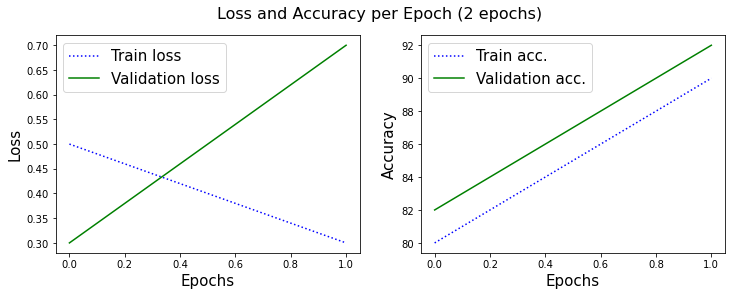

In [55]:
# test
smr = SimpleModelReporter()
smr.record_event(epoch_step=0, model_stage='train', metric_name='loss', metric_value=0.5)
smr.record_event(epoch_step=0, model_stage='train', metric_name='acc', metric_value=80.0)
smr.record_event(epoch_step=1, model_stage='train', metric_name='loss', metric_value=0.3)
smr.record_event(epoch_step=1, model_stage='train', metric_name='acc', metric_value=90.0)
smr.record_event(epoch_step=0, model_stage='val', metric_name='loss', metric_value=0.3)
smr.record_event(epoch_step=0, model_stage='val', metric_name='acc', metric_value=82.0)
smr.record_event(epoch_step=1, model_stage='val', metric_name='loss', metric_value=0.7)
smr.record_event(epoch_step=1, model_stage='val', metric_name='acc', metric_value=92.0)
smr.plot(verbose=True)

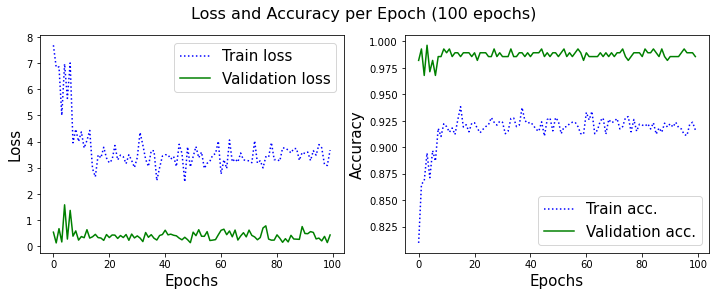

In [56]:
# test (using real data)
tensor = torch.tensor
epochs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
loss_train = [7.68595956642921, 6.8423265099934545, 6.857039376289107, 5.00449593370061, 6.973235242918171, 5.652400836769451, 7.008124781501859, 3.954760871821962, 4.471035438008382, 4.00293251418047, 4.372244527466483, 3.755254704336743, 4.043736311889919, 4.425795079929076, 2.96453165056333, 2.6530926406635325, 3.493043241889401, 3.3763476426661776, 3.782530717015217, 3.372186876514776, 3.185923465552551, 3.3057213295649386, 3.850546200484476, 3.299043043080153, 3.48215698985753, 3.4199111704293865, 3.1556493477425476, 3.497810921432496, 3.27637416921955, 3.008534708377359, 3.3850766871767655, 4.350187777614475, 3.8704215716537127, 3.3203274830611123, 3.049520936496689, 3.6530852347089153, 3.649817508063149, 2.5103028095490445, 3.005238857922714, 3.4469077444339273, 3.497781613145427, 3.4966953783846617, 3.333709729904406, 3.433263274205581, 3.0488406123549376, 3.89673738338546, 3.5484450117129582, 2.4615763979217906, 3.7973272654324552, 3.03168163532447, 3.4264159923879096, 3.8101234776741144, 3.381638651678731, 3.598858922378427, 2.9740324888516234, 3.1706718108929244, 3.249045074454414, 3.4834968933226236, 3.539148680497744, 4.012992329006953, 2.75954611663292, 3.306011018873107, 2.9702043285029487, 4.061631629598961, 3.2284908571942683, 3.337306468601355, 3.2195128849530126, 3.562905303542303, 3.297674853552878, 3.286024484852942, 3.2619223503596486, 3.192384833433352, 4.029238467682167, 3.1749672913218525, 3.269072958725552, 2.9946303399169003, 3.4225497964865315, 3.405711373932447, 3.9629062174104384, 3.307262777954132, 3.318095116400343, 3.2558073560560135, 3.7570360383989008, 3.753036714925381, 3.673243817090437, 3.5676087297137196, 3.731701198434563, 3.7330928610724623, 3.2846419029199097, 3.5879922827250867, 3.544278715828576, 3.5986178513068605, 3.2734945117424017, 3.654285492540826, 3.4790866080838447, 3.8860050733731004, 3.7633385536193575, 3.1157092864286646, 3.0856636629907555, 3.6759617020224873]
loss_val = [0.5345774446431019, 0.1242632918532885, 0.6698334158032326, 0.16087550280453697, 1.5821514577247633, 0.27138114575076944, 1.3687274819522024, 0.38227839649751283, 0.5840564437272243, 0.23192144407667975, 0.3684751859694856, 0.32333194569971246, 0.6300474710517956, 0.3095067853646662, 0.3586583211075831, 0.45171286392815313, 0.3270370401045365, 0.3116145858621175, 0.22169491176084952, 0.44461094413850416, 0.3289571955589253, 0.42722333911004406, 0.4227496959491997, 0.29561985877204955, 0.4064842019399143, 0.32959080213776054, 0.4454732836866841, 0.22474344598590992, 0.4633593883570299, 0.3151599075886511, 0.3930984900533076, 0.3107541121398222, 0.1757065011785136, 0.521530092790262, 0.34005256218985624, 0.4395213128088516, 0.30295266447743746, 0.2350568998239798, 0.40779621850817654, 0.44501302992441166, 0.6103382247139247, 0.43310135317371784, 0.4591391868526498, 0.4174414566091946, 0.3957415022326164, 0.30728829584110917, 0.24331287062721327, 0.34019801212099715, 0.24934282250701695, 0.132779109114082, 0.535504915642869, 0.4015714014234147, 0.6290884124813991, 0.3798690994292599, 0.3761546389856785, 0.5561542795593941, 0.21619357954759835, 0.23159485515928802, 0.2503913785206519, 0.43440678750977374, 0.6080046071380641, 0.6494566666356326, 0.43913571575545274, 0.5815843956598927, 0.3581519553433899, 0.6160422651847024, 0.23413116070022721, 0.3890021568235434, 0.5148816441933051, 0.3547039088569282, 0.6137283982421167, 0.41107823404166216, 0.35386511486451483, 0.2444937849367867, 0.33014942879859094, 0.6964619448939532, 0.7777400083988937, 0.2708693651752398, 0.2297879206592565, 0.23189218623975308, 0.43247280089137863, 0.3053654242574047, 0.14786074930777682, 0.2866340511009209, 0.16166626549444893, 0.4144152708784367, 0.27405821872415165, 0.26723285711737016, 0.2609142337118225, 0.750329765883883, 0.48457559563183644, 0.47704871709657776, 0.5569433647114092, 0.5250425862418316, 0.2774261325052401, 0.309290910880089, 0.20152508174472003, 0.3742258307924179, 0.13785357352566702, 0.42838323757122143]
acc_train = [tensor(0.8098, dtype=torch.float64), tensor(0.8652, dtype=torch.float64), tensor(0.8683, dtype=torch.float64), tensor(0.8946, dtype=torch.float64), tensor(0.8714, dtype=torch.float64), tensor(0.8969, dtype=torch.float64), tensor(0.8871, dtype=torch.float64), tensor(0.9179, dtype=torch.float64), tensor(0.9103, dtype=torch.float64), tensor(0.9223, dtype=torch.float64), tensor(0.9196, dtype=torch.float64), tensor(0.9143, dtype=torch.float64), tensor(0.9183, dtype=torch.float64), tensor(0.9121, dtype=torch.float64), tensor(0.9259, dtype=torch.float64), tensor(0.9384, dtype=torch.float64), tensor(0.9192, dtype=torch.float64), tensor(0.9214, dtype=torch.float64), tensor(0.9147, dtype=torch.float64), tensor(0.9228, dtype=torch.float64), tensor(0.9232, dtype=torch.float64), tensor(0.9179, dtype=torch.float64), tensor(0.9138, dtype=torch.float64), tensor(0.9170, dtype=torch.float64), tensor(0.9196, dtype=torch.float64), tensor(0.9214, dtype=torch.float64), tensor(0.9281, dtype=torch.float64), tensor(0.9237, dtype=torch.float64), tensor(0.9210, dtype=torch.float64), tensor(0.9246, dtype=torch.float64), tensor(0.9237, dtype=torch.float64), tensor(0.9129, dtype=torch.float64), tensor(0.9152, dtype=torch.float64), tensor(0.9272, dtype=torch.float64), tensor(0.9277, dtype=torch.float64), tensor(0.9196, dtype=torch.float64), tensor(0.9210, dtype=torch.float64), tensor(0.9375, dtype=torch.float64), tensor(0.9254, dtype=torch.float64), tensor(0.9228, dtype=torch.float64), tensor(0.9237, dtype=torch.float64), tensor(0.9210, dtype=torch.float64), tensor(0.9170, dtype=torch.float64), tensor(0.9152, dtype=torch.float64), tensor(0.9241, dtype=torch.float64), tensor(0.9107, dtype=torch.float64), tensor(0.9263, dtype=torch.float64), tensor(0.9277, dtype=torch.float64), tensor(0.9156, dtype=torch.float64), tensor(0.9281, dtype=torch.float64), tensor(0.9246, dtype=torch.float64), tensor(0.9129, dtype=torch.float64), tensor(0.9192, dtype=torch.float64), tensor(0.9196, dtype=torch.float64), tensor(0.9223, dtype=torch.float64), tensor(0.9237, dtype=torch.float64), tensor(0.9237, dtype=torch.float64), tensor(0.9196, dtype=torch.float64), tensor(0.9129, dtype=torch.float64), tensor(0.9125, dtype=torch.float64), tensor(0.9330, dtype=torch.float64), tensor(0.9259, dtype=torch.float64), tensor(0.9339, dtype=torch.float64), tensor(0.9129, dtype=torch.float64), tensor(0.9165, dtype=torch.float64), tensor(0.9250, dtype=torch.float64), tensor(0.9277, dtype=torch.float64), tensor(0.9125, dtype=torch.float64), tensor(0.9263, dtype=torch.float64), tensor(0.9232, dtype=torch.float64), tensor(0.9246, dtype=torch.float64), tensor(0.9272, dtype=torch.float64), tensor(0.9174, dtype=torch.float64), tensor(0.9196, dtype=torch.float64), tensor(0.9281, dtype=torch.float64), tensor(0.9290, dtype=torch.float64), tensor(0.9147, dtype=torch.float64), tensor(0.9263, dtype=torch.float64), tensor(0.9152, dtype=torch.float64), tensor(0.9219, dtype=torch.float64), tensor(0.9210, dtype=torch.float64), tensor(0.9201, dtype=torch.float64), tensor(0.9223, dtype=torch.float64), tensor(0.9174, dtype=torch.float64), tensor(0.9232, dtype=torch.float64), tensor(0.9125, dtype=torch.float64), tensor(0.9183, dtype=torch.float64), tensor(0.9143, dtype=torch.float64), tensor(0.9228, dtype=torch.float64), tensor(0.9192, dtype=torch.float64), tensor(0.9223, dtype=torch.float64), tensor(0.9192, dtype=torch.float64), tensor(0.9237, dtype=torch.float64), tensor(0.9187, dtype=torch.float64), tensor(0.9174, dtype=torch.float64), tensor(0.9121, dtype=torch.float64), tensor(0.9112, dtype=torch.float64), tensor(0.9219, dtype=torch.float64), tensor(0.9237, dtype=torch.float64), tensor(0.9165, dtype=torch.float64)]
acc_val = [tensor(0.9821, dtype=torch.float64), tensor(0.9929, dtype=torch.float64), tensor(0.9679, dtype=torch.float64), tensor(0.9964, dtype=torch.float64), tensor(0.9714, dtype=torch.float64), tensor(0.9821, dtype=torch.float64), tensor(0.9679, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9929, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9929, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9821, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9929, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9929, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9929, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9929, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9929, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9821, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9929, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9821, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9929, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9929, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9929, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9821, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9857, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9929, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9893, dtype=torch.float64), tensor(0.9857, dtype=torch.float64)]

rep = SimpleModelReporter()
for i in epochs:
    rep.record_event(i, 'train', 'acc', acc_train[i])
    rep.record_event(i, 'train', 'loss', loss_train[i])
    rep.record_event(i, 'val', 'acc', acc_val[i])
    rep.record_event(i, 'val', 'loss', loss_val[i])
rep.plot(verbose=False)

In [57]:
# TD: Now ready to train our model
# set the training hyperparameters:

# - we have a linear layer so use crossEntropyLoss 
# - use SGD optimiser with lr=0.01, momentum=0.9

# - define a learning rate scheduler
# -- decays the learning rate of the model params by gamma every step_size epochs
# -- learning rate decays by 0.1 every 7 epochs

# - instantiate simple reporter to allow visualisation of epoch loss and acc events

In [58]:
criterion = nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

reporter = SimpleModelReporter()

\# TD: define a helper func to train final layer, note:
- model is copied to device (in case we have cuda)

- define best_acc and best_model_wts to record best accuracy and corresponding model weights
 - these are a deep copy of the current model params from state dict

- run training for each epoch (1 pass through training data)
 - print current epoch and related info
 - after every epoch evaluate the data: iterate over train phase and then test phase
  - in training phase switch to train mode and call scheduler.step to update training params
  - in test phase switch to eval mode where batch normalisation and droput layers will be disabled
  - keep track of running loss and number of test predictions
  
  - load data from training or test (for appropriate phase), read data in batches
   - copy images and labels to device
   - zero out gradients of optimiser so that fresh grads will be calculated (only for linear layer) in backward pass 
    - update gradients for training phase only
      - make forward pass through model: run model on inputs, get predictions and calculate model loss (using criterion) on the output
      - if training then make backward pass through NN and update model params using gradients calculated
      - keep track of running loss of model and running correct predictions (actual=predicted)
      
 - calculate epoch accuracy for training and test
 - for test phase: determine if best model; if yes then save
 
- after training complete, show best and load model for best weights

In [59]:
# TD: add progress marker for each batch

In [60]:
def train_model(model, criterion, optimizer, scheduler, reporter, num_epochs=25):

    model = model.to(device)
    
    best_acc = 0.0
    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        
        print('\nEpoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'val']:
            
            if phase == 'train':
                #TD: call to scheduler moved to after call to optimiser following warning from pytorch 
#                 scheduler.step() 
                model.train()  
                
            else:
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                
                #TD: show more granular progress per batch
                print('.', end='')
                
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    
                    outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / total_batch_sizes[phase]
            epoch_acc = running_corrects.double() / (total_batch_sizes[phase] * batch_size)

            print('\n{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc
                ))
            
            # record loss and acc
            reporter.record_event(
                epoch_step=epoch, model_stage=phase, 
                metric_name='loss', metric_value=epoch_loss
                )
            reporter.record_event(
                epoch_step=epoch, model_stage=phase, 
                metric_name='acc', metric_value=epoch_acc
                )
                           
            if phase == 'train':
                #TD: call to scheduler moved to after call to optimiser following warning from pytorch 
                scheduler.step()
                
            if phase == 'val' and epoch_acc >= best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())


    print('\nTraining complete')

    print('Best Validation Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    
    return model

In [91]:
# History / Stats
# TD: run model for 10 epochs (note that is set to 1 on cpu)
# - as we are only training later layers of model then should only need a small number of epochs
# - and minimised cloud VM bill!
# - increased from 5 to 10 because using mobilenet_v2

# Janani's (Pluralsight) original run for cats and dogs dataset with 5 epochs on GPU showed best test accuracy of ~98%
# TD accuracy on 1 epoch on CPU showed accuracy of ~95% (with Wall time: 16min 1s)
# TD accuracy on 5 epochs on GPU showed accuracy of ~98.6% (with Wall time: 4min 5s)
# TD accuracy on 10 epochs on GPU showed accuracy of ~98.3% (with Wall time: 8min 6s)

# TD's run (Pluralsight FixedFeatureExtractor vgg16.ipynb) for cats and dogs dataset:
# TD accuracy on 1 epoch on CPU showed accuracy of ~97% (with Wall time: 10min 13s)

# TD's run for boo and simba dataset (vgg16)
# TD accuracy on 1 epoch on CPU showed accuracy of ~99% (with Wall time: 1min 28s)
# TD accuracy on 5 epoch on CPU showed accuracy of ~100% (with Wall time: 5min 45s)

# TD's run for boo and simba dataset (mobilenet_v2)
# TD accuracy on 1 epoch on CPU showed accuracy of ~99% (with Wall time: 36s)
# TD accuracy on 5 epoch on CPU showed accuracy of ~100% (with Wall time: 3min 30s)
# TD accuracy on 10 epoch on CPU showed accuracy of ~100% (with Wall time: 6min 3s)

# TD's run for boo and simba dataset (mobilenet_v2) 1000 images
# TD accuracy on 1 epoch on CPU showed accuracy of ~99% (with Wall time: 3min 29ss)
# TD accuracy on 5 epoch on CPU showed accuracy of ~99% (with Wall time: 13min 46s)
# TD accuracy on 10 epoch on CPU showed accuracy of ~100% (with Wall time: 27min 30s)
# TD accuracy on 100 epoch on CPU showed accuracy of ~100% (with Wall time: 4hr 50min 36s)
# TD accuracy on 100 epoch on kaggle GPU showed accuracy of ~100% (with Wall time: 40min 33s)

In [62]:
%%time
NUM_EPOCHS = 100
model = train_model(
    model, criterion, optimizer_ft, exp_lr_scheduler, 
    reporter, num_epochs=NUM_EPOCHS
)


Epoch 0/99
----------
........................................................................................................................................................................................................................................................................................
train Loss: 5.7174 Acc: 0.8420
...................................
val Loss: 0.4451 Acc: 0.9786

Epoch 1/99
----------
........................................................................................................................................................................................................................................................................................
train Loss: 5.4988 Acc: 0.8688
...................................
val Loss: 1.0942 Acc: 0.9786

Epoch 2/99
----------
.................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................
train Loss: 3.7727 Acc: 0.9259
...................................
val Loss: 0.3251 Acc: 0.9857

Epoch 41/99
----------
........................................................................................................................................................................................................................................................................................
train Loss: 3.6007 Acc: 0.9201
...................................
val Loss: 0.4847 Acc: 0.9893

Epoch 42/99
----------
......................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................
train Loss: 3.8760 Acc: 0.9268
...................................
val Loss: 0.2973 Acc: 0.9893

Epoch 81/99
----------
........................................................................................................................................................................................................................................................................................
train Loss: 3.8223 Acc: 0.9268
...................................
val Loss: 0.4361 Acc: 0.9821

Epoch 82/99
----------
......................................................................................................................................................................................................

Plot results from reporter

epochs:
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]
loss_train:
 [5.717411376759083, 5.498821677969057, 5.804552353359568, 6.843644164661607, 9.610515871460246, 7.05341746236012, 6.654060410828902, 4.76712065058974, 4.625404808899343, 4.615082694514191, 4.900616985081139, 4.163818815948239, 3.501421506170199, 4.696819766033848, 3.4530526296965123, 4.0905061063618815, 3.9012452165070663, 3.531485624950124, 4.091176570136604, 4.210933556604371, 4.138071163205635, 3.37152097523586, 4.480227243472679, 4.345600227722117, 4.516436186312816, 4.249007498876477, 3.734656878948146, 3.6209467202138375, 3.8160214654081384, 3.716404724482549, 4.468887838055

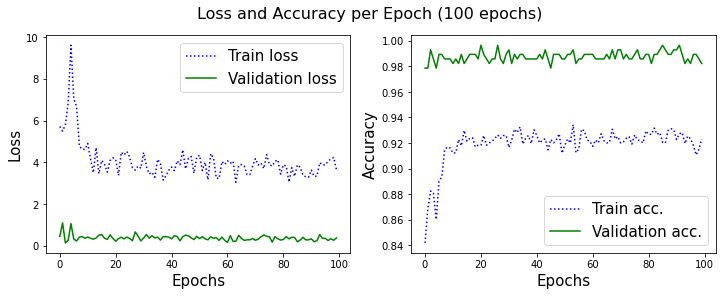

In [63]:
reporter.plot(verbose=True)

## Test model

\# TD: now let's use the model for predictions on *unseen* data
- switch to eval mode
- turn off gradient calcs for test
 - iterate over images and labels in test dataset in batches
  - copy images to required device
  - pass through model and get predicted labels
  - keep track of tot predictions and number correct predictions
- finally print accuracy on test data

Accuracy for TD model with catmon dataset (10 epoch, CPU) shows ~100.0%.

In [64]:
%%time
model.eval() 

with torch.no_grad():
    
    correct = 0
    total = 0
    
    for images, labels in dataloaders['test']:
        
        #TD: show more granular progress per batch
        print('.', end='')
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'\nAccuracy of the model on the test images: {(100 * correct / total):.2f}%')

...................................
Accuracy of the model on the test images: 99.64%
Wall time: 21.9 s


## Use model for prediction using test images

In [65]:
# TD: Show prediction (with image) for the first batch of test images

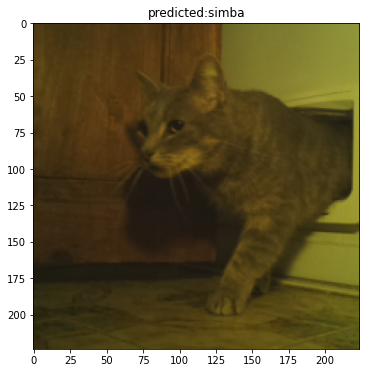

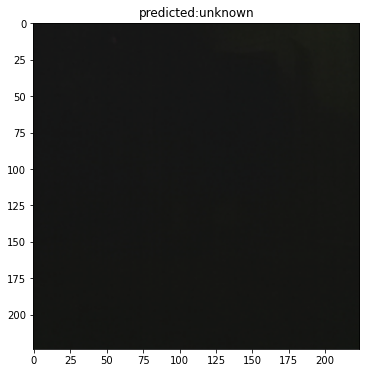

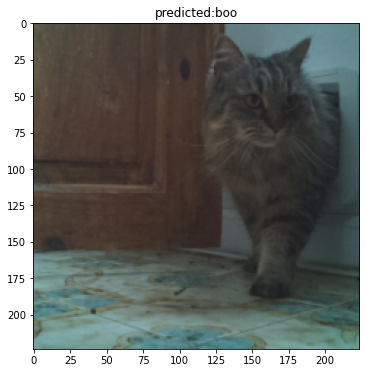

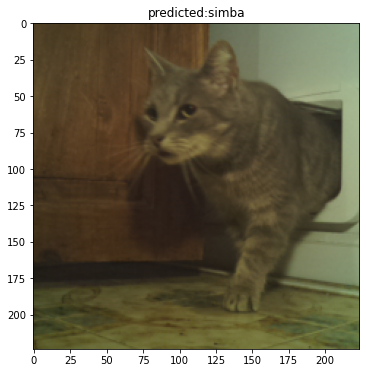

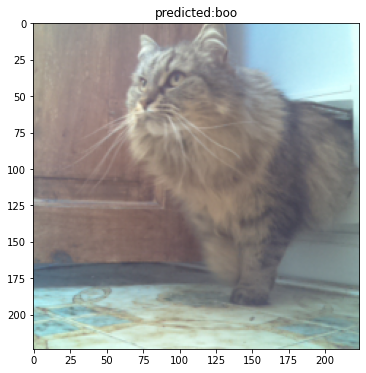

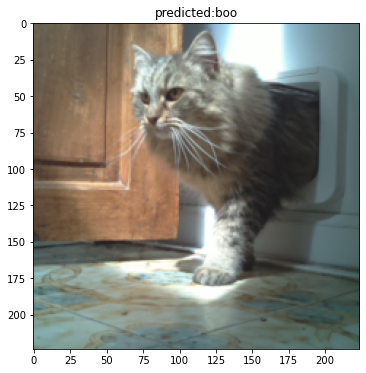

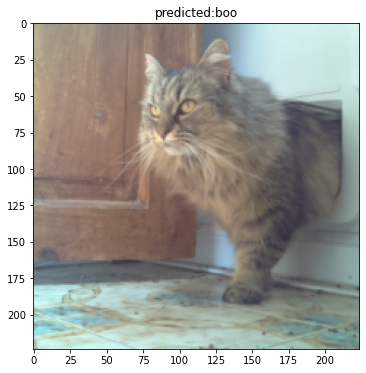

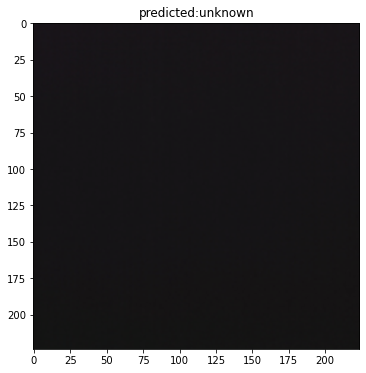

In [66]:
with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = model(inputs)
    _, preds = torch.max(outputs, 1)
    
    for j in range(len(inputs)):
        inp = inputs.data[j]
        imshow(inp, 'predicted:' + class_names[preds[j]])

Add probability

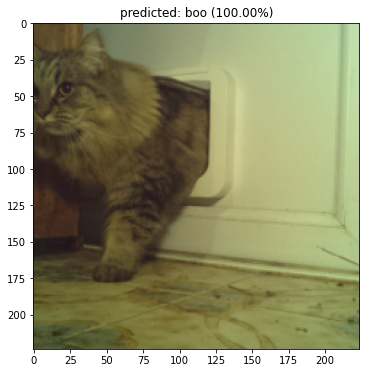

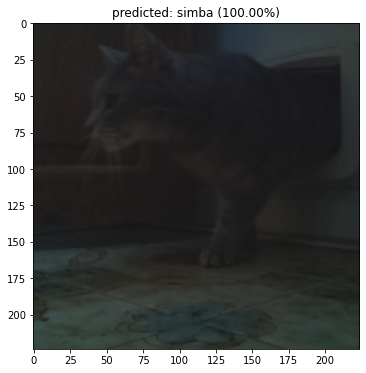

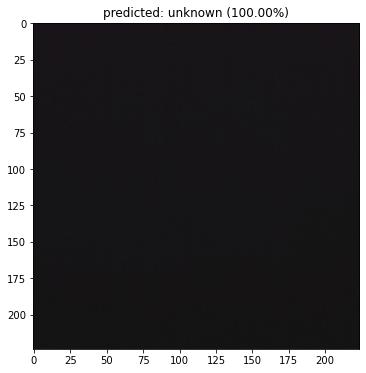

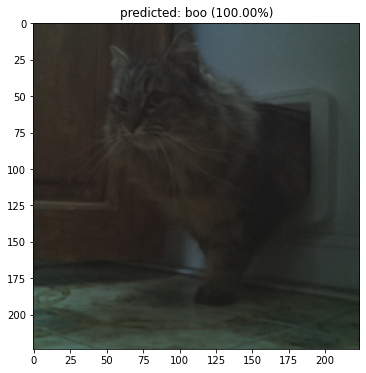

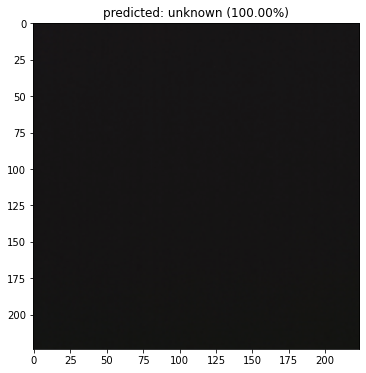

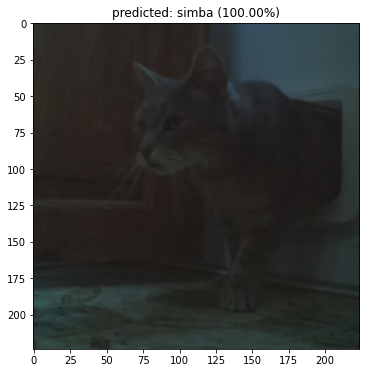

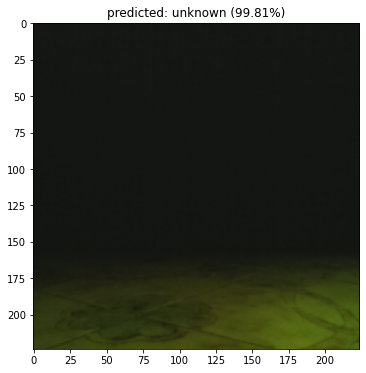

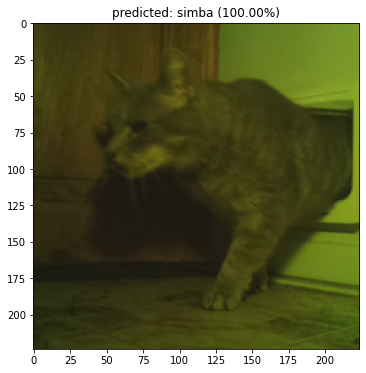

In [67]:
# https://discuss.pytorch.org/t/how-to-extract-probabilities/2720/15
sm = torch.nn.Softmax(dim=1)

with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = model(inputs)
    probs, preds = torch.max(outputs, 1)
    
    # calculate probabilities using softmax 
    probabilities = sm(outputs) 

    for j in range(len(inputs)):
        inp = inputs.data[j]
        
        label = class_names[preds[j]]        
        probability = probabilities[j][preds[j]]
        
        imshow(inp, f"predicted: {class_names[preds[j]]} ({probability:.2%})")

## Save trained model state dict

In [68]:
MOBILENET_V2_MODEL_SD = "models/catmon-img-classifier_mobilenet_v2_state_dict_0.3"

In [69]:
torch.save(model.state_dict(), MOBILENET_V2_MODEL_SD)

In [70]:
!dir models

 Volume in drive C is OS
 Volume Serial Number is 5470-E9D2

 Directory of C:\Users\Terry\Documents\Python\project-catmon-img-classifier\models

11/08/2022  19:39    <DIR>          .
11/08/2022  19:39    <DIR>          ..
09/07/2022  05:40         9,149,965 catmon-img-classifier_mobilenet_v2_state_dict_0.2
16/08/2022  18:13         9,149,965 catmon-img-classifier_mobilenet_v2_state_dict_0.3
23/06/2022  17:53       537,101,509 catmon-img-classifier_vgg16_state_dict_0.1
09/08/2022  14:33    <DIR>          tmp
               3 File(s)    555,401,439 bytes
               3 Dir(s)  248,746,278,912 bytes free


## Prepare new model and load the saved model params from state dict

In [71]:
# Instantiate the model
new_model = models.mobilenet_v2(pretrained=True)

# TD: extract number of input and output features from the model
num_ftrs = new_model.classifier[-1].in_features

# TD: Now change last linear layer of the model
# - change number of output categories to 3 (corresponding to our 3 catagories)
# - note that number of input features is unchanged (at 4096)

new_model.classifier[-1] = nn.Linear(num_ftrs, 3)

In [72]:
new_model.load_state_dict(torch.load(MOBILENET_V2_MODEL_SD))

<All keys matched successfully>

In [73]:
new_model

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

## Test accuracy of new model on unseen data 

In [74]:
%%time
new_model = new_model.to(device)

# Switch to eval mode and make precictions using test data
new_model.eval() 

with torch.no_grad():
    
    correct = 0
    total = 0
    
    for images, labels in dataloaders['test']:
        
        #TD: show more granular progress per batch
        print('.', end='')
        
        images = images.to(device)
        labels = labels.to(device)

        outputs = new_model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f"\nAccuracy of the new model on the test images: {100 * correct / total:.2f}%")

...................................
Accuracy of the new model on the test images: 99.64%
Wall time: 18.8 s


## Use new model for prediction using test images

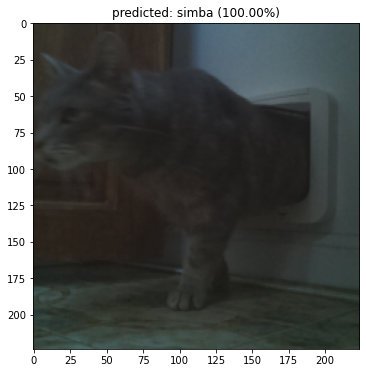

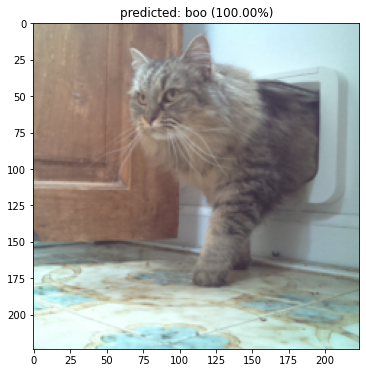

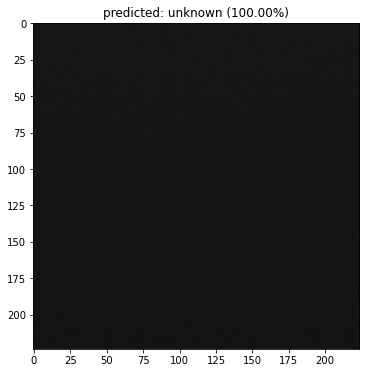

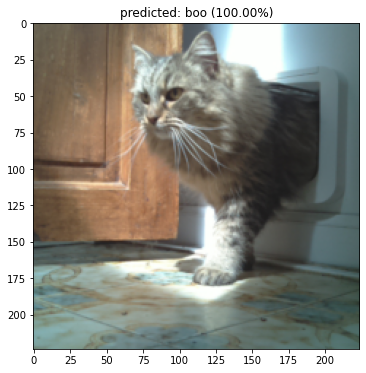

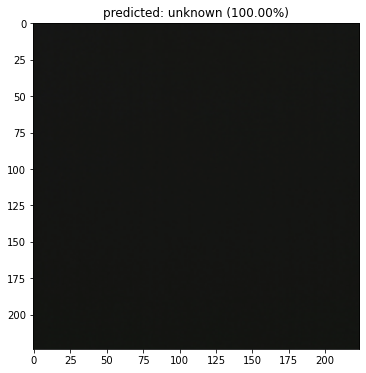

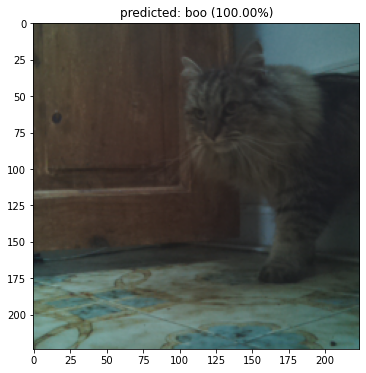

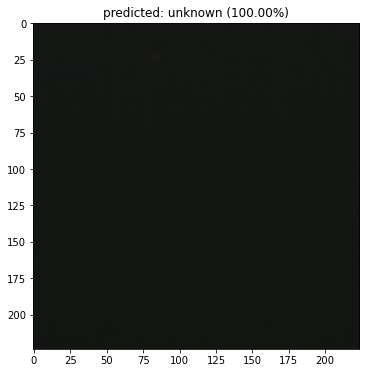

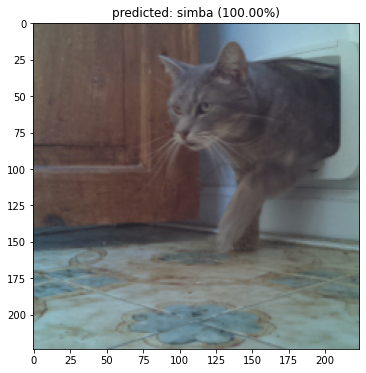

In [75]:
# https://discuss.pytorch.org/t/how-to-extract-probabilities/2720/15
sm = torch.nn.Softmax(dim=1)

with torch.no_grad():
    
    inputs, labels = iter(dataloaders['test']).next()
    
    inputs = inputs.to(device)
    labels = labels.to(device)
    
    inp = torchvision.utils.make_grid(inputs)
    
    outputs = new_model(inputs)
    probs, preds = torch.max(outputs, 1)
    
    # calculate probabilities using softmax 
    probabilities = sm(outputs) 

    for j in range(len(inputs)):
        inp = inputs.data[j]
        
        label = class_names[preds[j]]        
        probability = probabilities[j][preds[j]]
        
        imshow(inp, f"predicted: {class_names[preds[j]]} ({probability:.2%})")

## Use new model for prediction with new catmon images

In [77]:
# Transform boo image

# first convert jpg to pil
boo_pil_img = Image.open(BOO_IMAGE)

# apply transform to create the required tensor
tensor = test_transform(boo_pil_img)
tensor.shape

torch.Size([3, 224, 224])

In [78]:
# reshape tensor to add dummy batch
reshaped_tensor = tensor.unsqueeze(0)
reshaped_tensor.shape

torch.Size([1, 3, 224, 224])

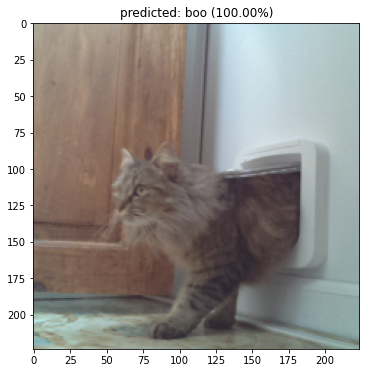

In [79]:
# classify the image
with torch.no_grad():
    
    inputs = reshaped_tensor.to(device)
    outputs = new_model(inputs)
    probs, preds = torch.max(outputs, 1)
    
    # calculate probabilities using softmax 
    probabilities = sm(outputs) 

    label = class_names[preds]
    probability = float(probabilities.flatten()[preds])
    
    img = inputs.data[0]
#     imshow(img, "title")

    imshow(img, f"predicted: {label} ({probability:.2%})")

In [80]:
def predict_catmon_image(model, jpg_image, display=True):
    """Return predicted label and probability for given model and jpg image.
    
    If display is True,
    Display image with predicted label and probability percentage, 
    
    """
    
    # convert jpg image to pil
    pil_img = Image.open(jpg_image)

    # apply transform to create the required tensor
    tensor = test_transform(pil_img)
    print(tensor.shape)
    
    # reshape tensor to add dummy batch
    reshaped_tensor = tensor.unsqueeze(0)
    print(reshaped_tensor.shape)
    
    # classify the image
    with torch.no_grad():

        inputs = reshaped_tensor.to(device)
        outputs = model(inputs)
        probs, preds = torch.max(outputs, 1)

        # calculate probabilities using softmax 
        probabilities = sm(outputs) 
        
        label = class_names[preds]
        probability = float(probabilities.flatten()[preds])

        print(probs, preds, probabilities)
        img = inputs.data[0]

    if display:
        imshow(img, f"predicted: {label} ({probability:.2%})")
    
    return label, probability

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([14.3389]) tensor([0]) tensor([[1.0000e+00, 1.1025e-11, 2.7972e-08]])


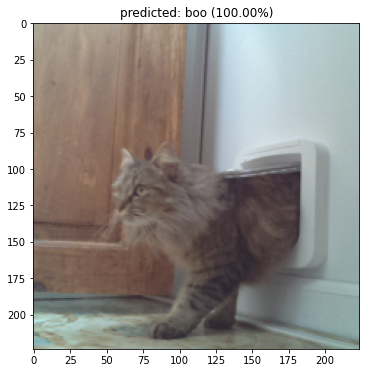

Wall time: 2.02 s


('boo', 1.0)

In [81]:
%%time
predict_catmon_image(new_model, BOO_IMAGE)

In [82]:
%%time
predict_catmon_image(new_model, BOO_IMAGE, display=False)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([14.3389]) tensor([0]) tensor([[1.0000e+00, 1.1025e-11, 2.7972e-08]])
Wall time: 67.9 ms


('boo', 1.0)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([25.7213]) tensor([1]) tensor([[1.2509e-20, 1.0000e+00, 1.8790e-14]])


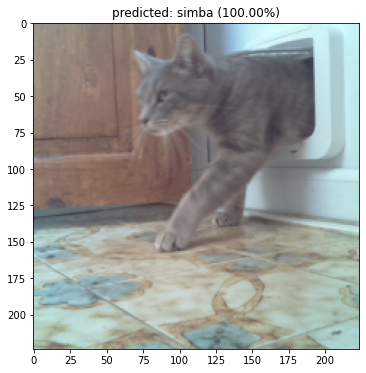

('simba', 1.0)

In [83]:
predict_catmon_image(new_model, SIMBA_IMAGE)

In [84]:
predict_catmon_image(new_model, SIMBA_IMAGE, display=False)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([25.7213]) tensor([1]) tensor([[1.2509e-20, 1.0000e+00, 1.8790e-14]])


('simba', 1.0)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([8.7131]) tensor([2]) tensor([[1.3427e-05, 3.4613e-07, 9.9999e-01]])


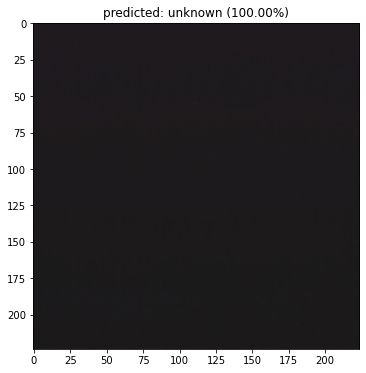

('unknown', 0.9999861717224121)

In [85]:
predict_catmon_image(new_model, UNKNOWN_IMAGE, display=True)

## Use new model for prediction with new random images

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([10.4161]) tensor([1]) tensor([[1.8733e-08, 1.0000e+00, 3.0977e-06]])


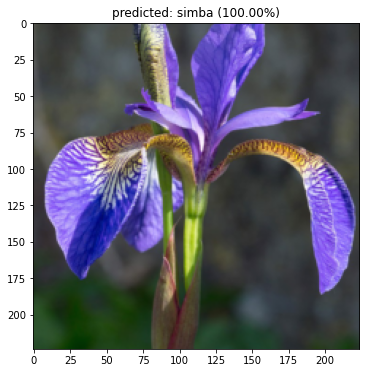

('simba', 0.9999969005584717)

In [86]:
predict_catmon_image(new_model, RANDOM_IMAGE1, display=True)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([4.0746]) tensor([2]) tensor([[0.0080, 0.0022, 0.9898]])


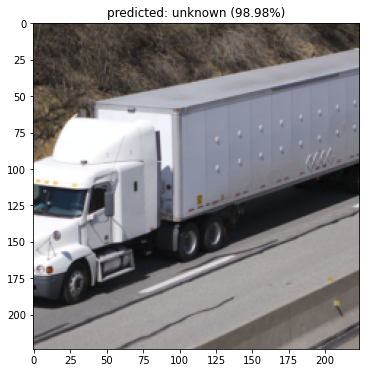

('unknown', 0.9897865056991577)

In [87]:
predict_catmon_image(new_model, RANDOM_IMAGE2, display=True)

## Use new model for prediction with new non-catmon images of boo and simba

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([21.2331]) tensor([0]) tensor([[1.0000e+00, 4.4117e-18, 3.4255e-11]])


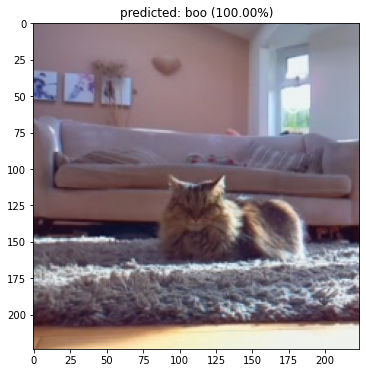

('boo', 1.0)

In [88]:
predict_catmon_image(new_model, BOO_NON_CATMON_IMAGE, display=True)

torch.Size([3, 224, 224])
torch.Size([1, 3, 224, 224])
tensor([11.4978]) tensor([0]) tensor([[1.0000e+00, 4.9301e-10, 2.4956e-06]])


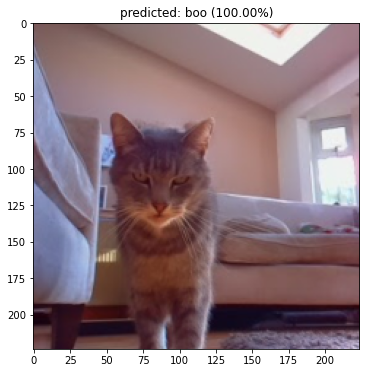

('boo', 0.9999974966049194)

In [89]:
predict_catmon_image(new_model, SIMBA_NON_CATMON_IMAGE, display=True)

In [90]:
# Note that model not trained with non-catmon images!
# And this was not an objective of the model.

# However, accuracy may be improved with these images by adding non-catmon 
# cat images to dataset and/or increasing size of dataset?